## good read

https://data.library.virginia.edu/is-r-squared-useless/

https://stats.stackexchange.com/questions/402059/standardised-mean-absolute-error-smae-and-how-to-calculate-it

https://stats.stackexchange.com/questions/131267/how-to-interpret-error-measures/131273#131273

In [1]:
%run correlate_evolution.ipynb

%cd /work/clusterEvo/new_tests/eggNOG/

/work/clusterEvo/new_tests/eggNOG


In [2]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr, mannwhitneyu
from scipy.spatial.distance import braycurtis
import igraph as ig
from Bio import SeqIO
import requests

In [3]:
single_copy = pd.read_parquet('single_copy_genes.parquet')
single_copy.head()

,group_id,num_proteins,num_taxa,members,taxa
1277,arCOG00079,112,112,"1041930.Mtc_1976,1054217.TALC_01539,1070774.J0...","[1041930, 1054217, 1070774, 1071085, 1094980, ..."
1279,arCOG00081,166,166,"1006006.Mcup_0318,1033806.HTIA_0777,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."
1519,arCOG00354,112,112,"1033806.HTIA_1426,1041930.Mtc_0671,1042877.GQS...","[1033806, 1041930, 1042877, 1070774, 1071085, ..."
1520,arCOG00355,106,106,"1033806.HTIA_0952,1041930.Mtc_0275,1042877.GQS...","[1033806, 1041930, 1042877, 1070774, 1071085, ..."
1561,arCOG00410,168,168,"1006006.Mcup_0164,1033806.HTIA_1385,1041930.Mt...","[1006006, 1033806, 1041930, 1042877, 1054217, ..."


In [4]:
eggNOG_trees = pd.read_csv('2157_trees.tsv',
                           sep      ='\t',
                           header   =None,
                           usecols  =[1,2,3],
                           index_col=0,
                           names    =['group_id', 'fast', 'tree'])
eggNOG_trees = eggNOG_trees.reindex(index=single_copy.group_id)

group_ids = []
trees     = []
for index, row in eggNOG_trees.iterrows():
    group_ids.append(index)
    trees.append(ete3.Tree(row.tree))

pool          = multiprocessing.Pool(processes = 10)
dist_matrices = pool.map(get_matrix_from_tree, trees)

# table = {group:matrix for group, matrix in zip(group_ids, dist_matrices)}

In [5]:
# del(dist_matrices)
# del(trees)
# del(group_ids)

# group_ids = []
# trees     = []
# for group_id in single_copy.group_id.values:
#     group_ids.append(group_id)
#     trees.append(ete3.Tree(f'trees/{group_id}.nwk'))

# pool          = multiprocessing.Pool(processes = 10)
# dist_matrices = pool.map(get_matrix_from_tree, trees)

In [6]:
def run_coevol(matrices):
    m1 = matrices[0].copy()
    m2 = matrices[1].copy()
    r2 = assess_coevolution(m1, m2, gene_sep='.', geneIDs=True)[1]
    
    return(r2)

matrix1 = dist_matrices[0].copy()
matrix2 = dist_matrices[1].copy()
run_coevol((matrix1, matrix2))

0.8713248922984702

In [7]:
pool   = multiprocessing.Pool(processes=10)
odr_r2 = np.array(pool.map(run_coevol, itertools.combinations(dist_matrices, 2)))

In [8]:
group_pairs = []
for pair in itertools.combinations(group_ids, 2):
    group_pairs.append(pair)

group_pairs = np.array(group_pairs)

In [9]:
odr_df = pd.DataFrame(columns=['group1', 'group2', 'Rsquared'],
                      data   =zip(group_pairs[:, 0],
                                  group_pairs[:, 1],
                                  odr_r2))

odr_df['group_pair'] = odr_df[['group1', 'group2']].agg(frozenset, axis=1)
odr_df.set_index('group_pair', inplace=True)

odr_df.head()

,group1,group2,Rsquared
group_pair,,,
"(arCOG00079, arCOG00081)",arCOG00079,arCOG00081,0.871325
"(arCOG00079, arCOG00354)",arCOG00079,arCOG00354,0.562008
"(arCOG00079, arCOG00355)",arCOG00079,arCOG00355,0.850273
"(arCOG00079, arCOG00410)",arCOG00079,arCOG00410,0.957535
"(arCOG00079, arCOG00487)",arCOG00079,arCOG00487,0.850984


In [10]:
def get_braycurtis(pair):
    (index1, row1), (index2, row2) = pair

    taxa1 = re.findall('(?:^|,)(\d+)', row1.members)
    taxa2 = re.findall('(?:^|,)(\d+)', row2.members)

    freq1 = Counter(taxa1)
    freq2 = Counter(taxa2)

    freq1_input = []
    freq2_input = []
    for taxon in set(taxa1).union(taxa2):
        if taxon in freq1:
            freq1_input.append(freq1[taxon])
        else:
            freq1_input.append(0)
        if taxon in freq2:
            freq2_input.append(freq2[taxon])
        else:
            freq2_input.append(0)    
            
    return(row1.group_id, 
           row2.group_id, 
           1 - braycurtis(freq1_input, freq2_input))

pool               = multiprocessing.Pool(processes=10)
braycurtis_indices = pool.map(get_braycurtis, 
                              itertools.combinations(single_copy.iterrows(), 2))

# braycurtis_indices = np.array(braycurtis_indices)

In [11]:
braycurtis_df = pd.DataFrame(columns=['group1', 'group2', 'braycurtis'],
                             data   =braycurtis_indices)

braycurtis_df['group_pair'] = braycurtis_df[['group1', 'group2']].agg(frozenset, axis=1)
braycurtis_df.set_index('group_pair', inplace=True)

In [12]:
odr_df = odr_df.join(braycurtis_df.braycurtis)

odr_df['coevol_metric'] = odr_df.Rsquared * odr_df.braycurtis

odr_df.reset_index(drop=True).to_parquet('odr_regression-single_copies.parquet')

odr_df.head()

,group1,group2,Rsquared,braycurtis,coevol_metric
group_pair,,,,,
"(arCOG00079, arCOG00081)",arCOG00079,arCOG00081,0.871325,0.798561,0.695806
"(arCOG00079, arCOG00354)",arCOG00079,arCOG00354,0.562008,0.857143,0.481721
"(arCOG00079, arCOG00355)",arCOG00079,arCOG00355,0.850273,0.807339,0.686459
"(arCOG00079, arCOG00410)",arCOG00079,arCOG00410,0.957535,0.800000,0.766028
"(arCOG00079, arCOG00487)",arCOG00079,arCOG00487,0.850984,0.800000,0.680787


In [13]:
def run_rf(trees):
    
    tmp_trees = []
    for _ in trees:
        tmp = _.copy()
        for leaf in tmp.get_leaves():
            leaf.name = leaf.name.split('.')[0]
            
        tmp_trees.append(tmp)
    
    tmp_rf = tmp_trees[0].robinson_foulds(tmp_trees[1])
    
    return(tmp_rf[0]/tmp_rf[1])

pool    = multiprocessing.Pool(processes=10)
rf_norm = pool.map(run_rf, itertools.combinations(trees, 2))

In [14]:
rf_df = pd.DataFrame(columns=['group1', 'group2', 'rf'],
                      data  =zip(group_pairs[:, 0],
                                 group_pairs[:, 1],
                                 rf_norm))

rf_df['group_pair'] = rf_df[['group1', 'group2']].agg(frozenset, axis=1)
rf_df.set_index('group_pair', inplace=True)

rf_df.head()

,group1,group2,rf
group_pair,,,
"(arCOG00079, arCOG00081)",arCOG00079,arCOG00081,0.633028
"(arCOG00079, arCOG00354)",arCOG00079,arCOG00354,0.489362
"(arCOG00079, arCOG00355)",arCOG00079,arCOG00355,0.500000
"(arCOG00079, arCOG00410)",arCOG00079,arCOG00410,0.527273
"(arCOG00079, arCOG00487)",arCOG00079,arCOG00487,0.563636


In [15]:
geo_matrix = pd.read_csv('geodesic_distances.csv', index_col=0)
geo_matrix = geo_matrix.reindex(index  =group_ids,
                                columns=group_ids)

triu_indices        = np.triu_indices_from(geo_matrix, k=1)
geo_df              = pd.DataFrame()
geo_df['group1']    = geo_matrix.index[ triu_indices[0]]
geo_df['group2']    = geo_matrix.index[ triu_indices[1]]
geo_df['geodesic' ] = geo_matrix.values[triu_indices]

geo_df['group_pair'] = geo_df[['group1', 'group2']].agg(frozenset, axis=1)

geo_df.head()

,group1,group2,geodesic,group_pair
0,arCOG00079,arCOG00081,2.788086,"(arCOG00079, arCOG00081)"
1,arCOG00079,arCOG00354,6.945581,"(arCOG00079, arCOG00354)"
2,arCOG00079,arCOG00355,3.927274,"(arCOG00079, arCOG00355)"
3,arCOG00079,arCOG00410,2.055330,"(arCOG00079, arCOG00410)"
4,arCOG00079,arCOG00487,3.463589,"(arCOG00079, arCOG00487)"


In [16]:
string = pd.read_parquet('duplications/few_duplications-string.parquet')

string = string.query('group1 in @single_copy.group_id & '
                      'group2 in @single_copy.group_id').copy()

string['group_pair'] = string[['group1', 'group2']].agg(frozenset, axis=1)
string.drop_duplicates(subset='group_pair', inplace=True)

# strongly_related = string.query('combined_score >= 900')
# weakly_related   = string.query('combined_score <= 200')
neighors     = string.query('neighborhood >= 700')
not_neighors = string.query('neighborhood <= 200')


data_columns = ['Rsquared', 'coevol_metric', 'braycurtis']

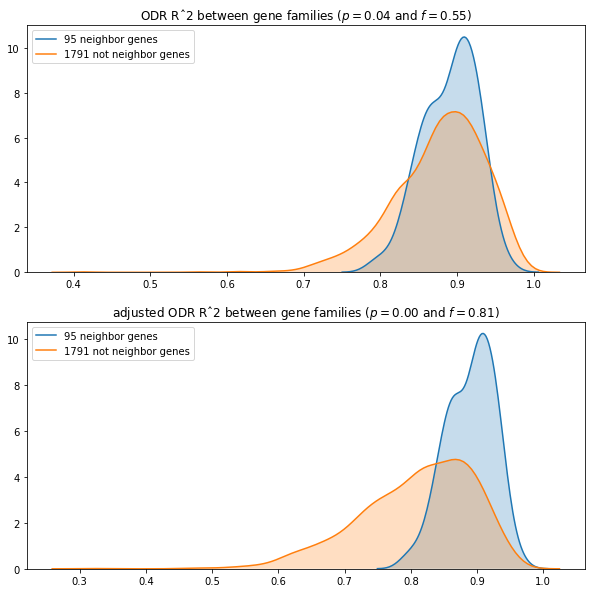

In [17]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
for ax, column in zip(axs, data_columns):
    
    neighors     = string.query('neighborhood >= 700')
    not_neighors = string.query('neighborhood <= 200')

    neighors_odr     = odr_df.query('group_pair in @neighors.group_pair'    )[column].values
    not_neighors_odr = odr_df.query('group_pair in @not_neighors.group_pair')[column].values

    hypothesis = mannwhitneyu(not_neighors_odr,
                              neighors_odr)
    
    if column == 'mse':
        effect_size = cles(neighors_odr, not_neighors_odr)
    else:
        effect_size = cles(not_neighors_odr, neighors_odr)

    sns.kdeplot(neighors_odr, shade=True,     label=f'{len(neighors_odr)} neighbor genes',     ax=ax)
    sns.kdeplot(not_neighors_odr, shade=True, label=f'{len(not_neighors_odr)} not neighbor genes', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'adjusted ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

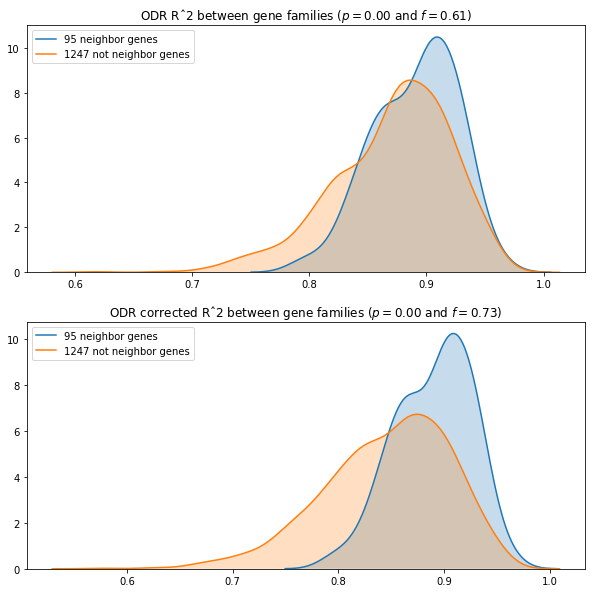

In [18]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
for ax, column in zip(axs, data_columns):
    
    neighors_odr     = odr_df.query('group_pair in @neighors.group_pair  & braycurtis >= 0.9'    )[column].values
    not_neighors_odr = odr_df.query('group_pair in @not_neighors.group_pair & braycurtis >= 0.9')[column].values

    hypothesis = mannwhitneyu(not_neighors_odr,
                              neighors_odr)
    
    if column == 'mse':  
        effect_size = cles(neighors_odr, not_neighors_odr)
    else:
        effect_size = cles(not_neighors_odr, neighors_odr)

    sns.kdeplot(neighors_odr, shade=True,     label=f'{len(neighors_odr)} neighbor genes',     ax=ax)
    sns.kdeplot(not_neighors_odr, shade=True, label=f'{len(not_neighors_odr)} not neighbor genes', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'ODR corrected Rˆ2 between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

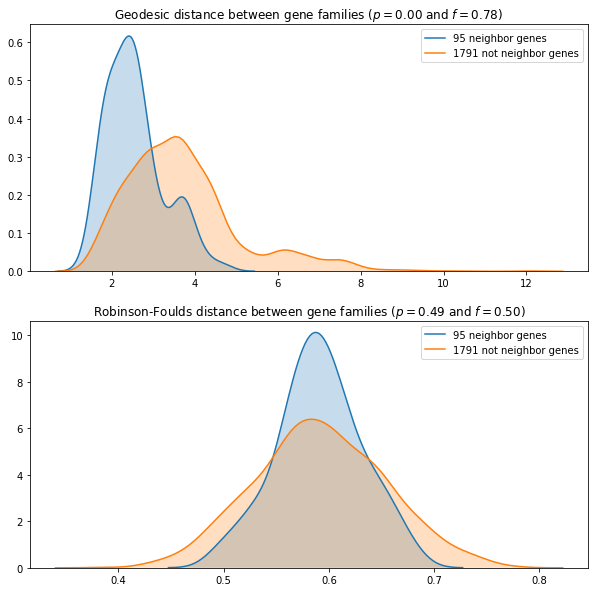

In [19]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
    
neighors_geo     = geo_df.query('group_pair in @neighors.group_pair'    ).geodesic.values
not_neighors_geo = geo_df.query('group_pair in @not_neighors.group_pair').geodesic.values

hypothesis = mannwhitneyu(neighors_geo,
                          not_neighors_geo)
effect_size = cles(neighors_geo, 
                   not_neighors_geo)

sns.kdeplot(neighors_geo,     shade=True, label=f'{len(neighors_geo)} neighbor genes',     ax=axs[0])
sns.kdeplot(not_neighors_geo, shade=True, label=f'{len(not_neighors_geo)} not neighbor genes', ax=axs[0])
axs[0].set_title(f'Geodesic distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');

neighors_rf     = rf_df.query('group_pair in @neighors.group_pair'    ).rf.values
not_neighors_rf = rf_df.query('group_pair in @not_neighors.group_pair').rf.values

hypothesis = mannwhitneyu(neighors_rf,
                          not_neighors_rf)
effect_size = cles(neighors_rf, 
                   not_neighors_rf)

sns.kdeplot(neighors_rf,     shade=True, label=f'{len(neighors_rf)} neighbor genes',     ax=axs[1])
sns.kdeplot(not_neighors_rf, shade=True, label=f'{len(not_neighors_rf)} not neighbor genes', ax=axs[1])
axs[1].set_title(f'Robinson-Foulds distance between gene families ($p={hypothesis.pvalue:.2f}$ and $f={effect_size:.2f}$)');